# Import libraries

In [1]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import gc # Note: this is a garbage collector
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') 

# Bring in data

In [2]:
PATH = r"..\Raw_Data"

In [3]:
data = {
    'airStore':  pd.read_csv(PATH + r"\air_store_info.csv"),
    'airVisit':  pd.read_csv(PATH + r"\air_visit_data.csv"),
    'date':      pd.read_csv(PATH + r"\date_info.csv"),
    'sampleSub': pd.read_csv(PATH + r"\sample_submission.csv"),
    'storeIDs':  pd.read_csv(PATH + r"\store_id_relation.csv")    
}

# Preprocess data

In [4]:
data['airVisit']['visit_date'].max()

'2017-04-22'

In [5]:
data['date']['visit_date'] = pd.to_datetime(data['date']['calendar_date'])
data['date'].drop('calendar_date', axis = 1 , inplace=True)

In [6]:
data['airVisit']['visit_date'] = pd.to_datetime(data['airVisit']['visit_date'])
data['airVisit']['dow'] = data['airVisit']['visit_date'].dt.dayofweek
data['airVisit']['year'] = data['airVisit']['visit_date'].dt.year
data['airVisit']['month'] = data['airVisit']['visit_date'].dt.month

## Add EWMA of visits as feature

Function to calculate ewm (note, found this on the competition discussion forum):

In [7]:
def calc_shifted_ewm(series, alpha, adjust = True):
    return series.shift().ewm(alpha = alpha, adjust = adjust).mean()

In [8]:
# Step below adds the ewm by day of week. Right now I'm returning a separate series so I can look at what each step does if I want to
tmp = data['airVisit'].groupby(['air_store_id','dow']).apply(lambda x: calc_shifted_ewm(x['visitors'], 0.1)) 
# This step backfills the 1st week's dow for each restaurant, otherwise it would be NaN since it's a 1-period ewma
tmp = tmp.fillna(method='bfill')
# The groupby function returns a multiIndex Series. I only need the 3rd level (original df index) to add column to original df
tmp.index = tmp.index.get_level_values(2)
# Sort index before adding back to original df
tmp = tmp.sort_index()

In [9]:
data['airVisit']['ewma'] = tmp

## Add 'days since last' and 'days until next' holiday

In [10]:
# Create a 'days since holiday' feature
daysSinceList = []
daysSinceHol = 0 # initialize daysSince counter
for row in data['date']['holiday_flg']:
    if row == 1:
        daysSinceHol = 0
        daysSinceList.append(daysSinceHol)
    else:
        daysSinceHol += 1
        daysSinceList.append(daysSinceHol)
data['date']['days_since_holiday'] = daysSinceList

In [11]:
# Create a 'days UNTIL next holiday' feature
holidayList = list(data['date']['holiday_flg'])
daysUntilHolList = np.zeros(len(holidayList),dtype=np.int)
daysUntilHol = 0 # initialize daysUntilHol counter
for i in range(len(holidayList)-1,0,-1):
    if holidayList[i] == 1:
        daysUntilHol = 0
        daysUntilHolList[i] = daysUntilHol
    else:
        daysUntilHol += 1
        daysUntilHolList[i] = daysUntilHol        
data['date']['days_until_holiday'] = daysUntilHolList

## Merge air_visits with date dframe to get holiday info

In [12]:
colsToMerge = ['holiday_flg','visit_date','days_until_holiday','days_since_holiday']
df_train = pd.merge(data['airVisit'], data['date'][colsToMerge], how = 'left', on = 'visit_date')

## Filter only the stores that must be predicted

In [13]:
df_test = data['sampleSub']

df_test['visit_date'] = df_test['id'].map(lambda x: str(x).split('_')[2])
df_test['air_store_id'] = df_test['id'].map(lambda x: '_'.join(str(x).split('_')[:2]))
df_test['visit_date'] = pd.to_datetime(df_test['visit_date'])
df_test['dow'] = df_test['visit_date'].dt.dayofweek
df_test['year'] = df_test['visit_date'].dt.year
df_test['month'] = df_test['visit_date'].dt.month

unique_stores = df_test['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)
#stores.head()

## Merge df_test with date dframe to get holiday info

In [14]:
df_test = pd.merge(df_test, data['date'][colsToMerge], how = 'left', on = 'visit_date')

In [15]:
stores = pd.merge(stores, data['airStore'], how='left', on=['air_store_id'])
#stores.head()

In [16]:
# Encode categorical string variables 
lbl = LabelEncoder()
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

### Add genre and area to train and test data

In [17]:
df_train = pd.merge(df_train, stores, how = 'left', on = ['air_store_id','dow'])

### Add visitor statistics as features

In [18]:
tmp = df_train.groupby(['air_store_id','dow']).agg({'visitors' : [np.min,np.mean,np.median,np.max,np.size]}).reset_index()
tmp.columns = ['air_store_id', 'dow', 'min_visitors', 'mean_visitors', 'median_visitors','max_visitors','count_observations']
df_train = pd.merge(df_train, tmp, how='left', on=['air_store_id','dow'])

In [19]:
df_test = pd.merge(df_test, stores, how = 'left', on = ['air_store_id','dow'])

In [20]:
df_test = pd.merge(df_test, tmp, how='left', on=['air_store_id','dow'])

Note: For XGB, didn't fillna (1/28/2018)
Other algorithms need fillna. TODO: 1) investigate why there are NaN on train set. 2) Check if XGBoost gets better score with fillna

In [21]:
df_train = df_train.fillna(-1)
df_test = df_test.fillna(-1)

In [23]:
train = df_train
test = df_test
col = [c for c in train if c not in ['id', 'air_store_id','visit_date','visitors']]

In [39]:
test.head()

,id,visitors,visit_date,air_store_id,dow,year,month,holiday_flg,days_until_holiday,days_since_holiday,air_genre_name,air_area_name,latitude,longitude,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
visit_date,,,,,,,,,,,,,,,,,,,
2017-04-23,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4,0,6,34,6,44,35.694004,139.753601,2.0,2.000000,2.0,2.0,1.0
2017-04-24,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4,0,5,35,6,44,35.694004,139.753601,1.0,22.457144,19.0,47.0,35.0
2017-04-25,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4,0,4,36,6,44,35.694004,139.753601,1.0,24.350000,24.5,43.0,40.0
2017-04-26,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4,0,3,37,6,44,35.694004,139.753601,15.0,28.125000,28.0,52.0,40.0
2017-04-27,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4,0,2,38,6,44,35.694004,139.753601,15.0,29.868422,30.0,47.0,38.0


# Initialize XGBoost
Note - code based on:
https://www.kaggle.com/jmbull/no-xgb-starter-here-s-one-lb-507

In [24]:
# XGB starter template borrowed from @anokas
# https://www.kaggle.com/anokas/simple-xgboost-starter-0-0655

print('Binding to float32')

for c, dtype in zip(df_train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)
        
for c, dtype in zip(df_test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)

Binding to float32


### Use cell below for validation using same weeks as test set but in the 2016 year

In [25]:
# Create training / validation split based on weeks in test set
x_train_setup = train.set_index('visit_date')

x_valid = x_train_setup['2016-04-23':'2016-05-31'].reset_index()
x_train = pd.concat([x_train_setup['2016-01-01':'2016-04-22'],
                     x_train_setup['2016-05-01':'2017-04-22']]).reset_index()

# Note: taking the absolute values makes the training take a VERY long time. I will instead take the log values
y_train = x_train['visitors']
y_valid = x_valid['visitors']

#y_train = np.log1p(x_train['visitors'].values)
#y_valid = np.log1p(x_valid['visitors'].values)

x_train = x_train.drop(['air_store_id','visit_date','visitors','ewma'], axis=1)
x_valid = x_valid.drop(['air_store_id','visit_date','visitors','ewma'], axis=1)

# Get Column order for x_test df
colOrder = x_train.columns

### Use cell below for validation using split based on last rows in train dataframe

In [26]:
#x_train = train.drop(['air_store_id','visit_date','visitors'], axis=1)
#y_train = np.log1p(train['visitors'].values)

# Get Column order for x_test df
#colOrder = x_train.columns

In [27]:
# Create training / validation split
#split = 200000
#x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

#print('Building DMatrix...')

In [28]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

#del x_train, x_valid; gc.collect()

In [29]:
print('Training ...')

params = {}
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params['eta'] = 0.04
params['max_depth'] = 5
params['silent'] = 1

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=100)

#del d_train, d_valid

Training ...
[0]	train-rmse:25.5606	valid-rmse:27.1448
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[100]	train-rmse:10.8041	valid-rmse:11.5663
[200]	train-rmse:10.5413	valid-rmse:11.1436
[300]	train-rmse:10.3738	valid-rmse:10.9049
[400]	train-rmse:10.2403	valid-rmse:10.7702
[500]	train-rmse:10.1255	valid-rmse:10.6269
[600]	train-rmse:10.0411	valid-rmse:10.5659
[700]	train-rmse:9.96551	valid-rmse:10.4779
[800]	train-rmse:9.8962	valid-rmse:10.3402
[900]	train-rmse:9.82988	valid-rmse:10.283
[1000]	train-rmse:9.77936	valid-rmse:10.189
[1100]	train-rmse:9.7286	valid-rmse:10.1329
[1200]	train-rmse:9.68415	valid-rmse:10.0863
[1300]	train-rmse:9.63906	valid-rmse:10.0306
[1400]	train-rmse:9.59979	valid-rmse:9.976
[1500]	train-rmse:9.56391	valid-rmse:9.92684
[1600]	train-rmse:9.53171	valid-rmse:9.88994
[1700]	train-rmse:9.49806	valid-rmse:9.84368
[1800]	train-rmse:9.46552	valid-rmse:9.79773
[190

In [30]:
#print(clf.feature_names)
#xgb.plot_tree(clf, num_trees=0,rankdir='LR')
#fig = plt.gcf()
#fig.set_size_inches(150, 100)
#fig.savefig('tree.png')

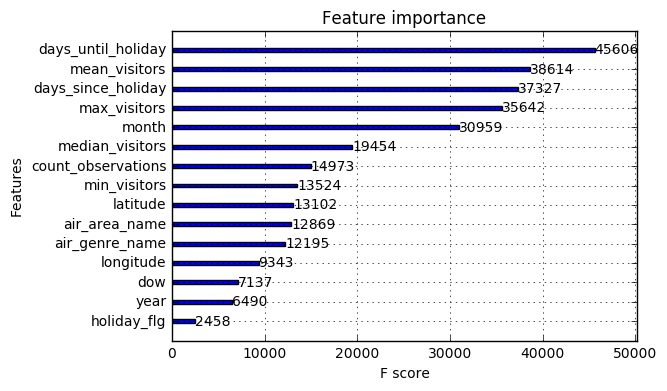

In [31]:
xgb.plot_importance(clf)

# Save the XBoost trained model

In [32]:
import pickle

In [32]:
pickle.dump(clf, open("recruit_rest_xgb.pickle.dat","wb"))

NOTE: To later retrieve the trained model, use command below: 

taken from:
https://machinelearningmastery.com/save-gradient-boosting-models-xgboost-python/

In [33]:
load_model = pickle.load(open("recruit_rest_xgb.pickle.dat","rb"))

#### Use ewma feature in test set
1. Assign ewma to 1st week of test set using last week of training
2. Predict
3. Calc ewma for 2nd week of test set
4. predict again

In [34]:
# Get dataframe for last week of training set and only use store
x_train_lastWk = train[['air_store_id','visit_date','dow']]
x_train_lastWk = x_train_lastWk[x_train_lastWk['visit_date'] > '2017-04-15']

In [35]:
# Split test by weeks [note that weeks start on day 6 (Sunday) rather than day 0 (Monday)]
test.index = test['visit_date']

testWk1 = test['2017-04-23':'2017-04-29']
testWk2 = test['2017-04-30':'2017-05-06']
testWk3 = test['2017-05-07':'2017-05-13']
testWk4 = test['2017-05-14':'2017-05-20']
testWk5 = test['2017-05-21':'2017-05-27']
testWk6 = test['2017-05-28':'2017-06-01']

In [36]:
testWk1_pred = pd.merge(testWk1, x_train_lastWk.drop('visit_date',axis=1),how='left',on=['air_store_id','dow'])

In [37]:
#testWk1_pred['ewma'] = testWk1_pred['ewma'].fillna(value=0)

In [38]:
testWk1_pred.head()

,id,visitors,visit_date,air_store_id,dow,year,month,holiday_flg,days_until_holiday,days_since_holiday,air_genre_name,air_area_name,latitude,longitude,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4,0,6,34,6,44,35.694004,139.753601,2.0,2.000000,2.0,2.0,1.0
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4,0,5,35,6,44,35.694004,139.753601,1.0,22.457144,19.0,47.0,35.0
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4,0,4,36,6,44,35.694004,139.753601,1.0,24.350000,24.5,43.0,40.0
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4,0,3,37,6,44,35.694004,139.753601,15.0,28.125000,28.0,52.0,40.0
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4,0,2,38,6,44,35.694004,139.753601,15.0,29.868422,30.0,47.0,38.0


Command to put columns in the right order for the XGBoost prediction

In [40]:
# NOTE: USE COLUMN LIST BELOW IF NOT INCLUDING VISITOR STATISTICS IN TRAINING SET

#columnsForTest_df = ['dow', 'year', 'month', 'ewma', 'holiday_flg', 'days_until_holiday',
#       'days_since_holiday', 'air_genre_name', 'air_area_name', 'latitude',
#       'longitude']

# NOTE: USE COLUMN LIST BELOW IF INCLUDING VISITOR STATISTICS IN TRAINING SET
columnsForTest_df = ['dow', 'year', 'month', 'holiday_flg', 'days_until_holiday', 'days_since_holiday',
                     'air_genre_name', 'air_area_name', 'latitude', 'longitude', 'min_visitors', 'mean_visitors',
                     'median_visitors', 'max_visitors', 'count_observations']

In [43]:
test = test[columnsForTest_df]
test = test.reset_index()
test = test[columnsForTest_df]

In [44]:
d_test = xgb.DMatrix(test)
print('Predicting on test ...')
p_test = clf.predict(d_test)
#del d_test; gc.collect()

Predicting on test ...


In [46]:
test['visitors'] = p_test
test['id'] = data['sampleSub']['id']
test[['id','visitors']].to_csv('xgb_submission_noEWMA.csv', index=False, float_format='%.3f')